In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import pickle
import gc
from tqdm.notebook import tqdm
from collections import deque

In [2]:
with open("simplified_data_v2/train_features_v2.pkl",'rb') as f:
    X = pickle.load(f)
with open("simplified_data_v2/train_labels_v2.pkl",'rb') as f:
    y = pickle.load(f)

In [3]:
y_scaled = y.clip(0,40)
y_scaled = np.log1p(y_scaled)/np.log1p(40)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled,test_size=0.2)
del X; gc.collect();

In [6]:
X_test.shape

(483055, 2, 19)

In [11]:
model_lstm = Sequential()
model_lstm.add(LSTM(256, input_shape=(2,19), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(64))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1, activation='sigmoid'))
model_lstm.compile(loss='mse', optimizer='adam', metrics=['accuracy']) # Increase Learning rate by steps of 0.1
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 2, 256)            282624    
_________________________________________________________________
dropout_3 (Dropout)          (None, 2, 256)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 364,865
Trainable params: 364,865
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=128)

Train on 1932216 samples, validate on 483055 samples
Epoch 1/50
1932216/1932216 [==============================] - 190s 98us/sample - loss: 0.0133 - accuracy: 0.5900 - val_loss: 0.0129 - val_accuracy: 0.5898
Epoch 2/50
1932216/1932216 [==============================] - 194s 100us/sample - loss: 0.0129 - accuracy: 0.5900 - val_loss: 0.0127 - val_accuracy: 0.5898
Epoch 3/50
1932216/1932216 [==============================] - 201s 104us/sample - loss: 0.0127 - accuracy: 0.5900 - val_loss: 0.0127 - val_accuracy: 0.5899
Epoch 4/50
1932216/1932216 [==============================] - 192s 99us/sample - loss: 0.0126 - accuracy: 0.5900 - val_loss: 0.0126 - val_accuracy: 0.5899
Epoch 5/50
1932216/1932216 [==============================] - 187s 97us/sample - loss: 0.0126 - accuracy: 0.5900 - val_loss: 0.0125 - val_accuracy: 0.5898
Epoch 6/50
1932216/1932216 [==============================] - 191s 99us/sample - loss: 0.0125 - accuracy: 0.5900 - val_loss: 0.0125 - val_accuracy: 0.5899
Epoch 7/50
1932

In [13]:
y_pre = model_lstm.predict(X_test)

In [14]:
y_pre_unscaled = np.expm1(y_pre * np.log1p(40))
y_unscaled = np.expm1(y_test * np.log1p(40))

Val RMSE: 1.246


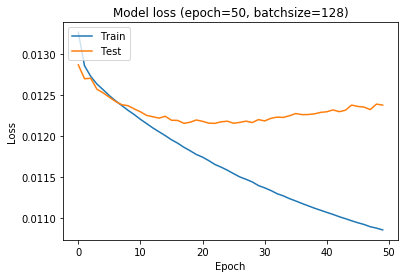

In [16]:
from sklearn.metrics import mean_squared_error
from numpy import sqrt
rmse = sqrt(mean_squared_error(y_pre_unscaled,y_unscaled))
print('Val RMSE: %.3f' % rmse)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (epoch=50, batchsize=128)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
model_lstm.save("LSTM_Model_v3.h5")

In [18]:
with open("LSTM_history_LSTM_model_v3.pkl",'wb') as f:
    pickle.dump(history.history,f)